# PERSIPAN PUSTAKA

Pustaka dipakai:
1. selenium
2. beautifulsoup4
3. paddleOCR
4. cv2
5. pandas
6. geopandas
7. shapely
8. matplotlib

In [1]:
# Library for Scrape
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup as bs
from a_selenium_click_on_coords import click_on_coordinates

# Visualization
from matplotlib import pyplot as plt
import cv2

# Text Recognition
from paddleocr import PaddleOCR, draw_ocr

# Polygon Manipulation
from shapely.geometry import Polygon, box, Point
from shapely import distance

# Dataframe Management
import geopandas as gpd
import pandas as pd
import numpy as np

# Runtime Monitoring
import time

Alur:
1. Import file SHP
2. Ekstrak polygon dari kelurahan yang ditentukan
3. Buat grid untuk mempermudah menentukan lokasi screenshot
    * Lakukan screenshot untuk dua level zoom mengetahui resolusi yang tersedia
    * ukuran grid ditentukan berdasarkan resolusi yang diperoleh
4. Buat screenshot layar berdasarkan grid yang terbentuk
5. Dapatkan nama tempat dengan ocr, sekaligus koordinat pada layar
6. Hapus teks yang merupakan menu dari Google Maps
7. Hapus teks yang berupa nama jalan
8. Klik setiap nama tempat yang didapat
9. Dapatkan koordinat POI melalui link
10. Dapatkan detail dari tempat menggunakan bs4
11. Ulangi tahapan 4 - 10 untuk setiap grid yan didapat

# CONFIG PARAMETER

In [2]:
#path shp file
path_shp = "SHPFile Kota Sukabumi/3272.shp"

#pilih kelurahan
kecamatan = "Cikole"
kelurahan = "Cikole"

#folder output
path_output = "output/"

# CONFIG SELENIUM DRIVER AND BROWSER

In [3]:
#windows option
chrome_options = Options()
chrome_options.add_argument("--start-maximized") # windows size
chrome_options.add_experimental_option("detach",True)

#zoom gmaps
zoom1 = 20
zoom2 = 20.5
zoom3 = 21

#test coordinat
lat_test = -6.7135171
long_test = 107.6786505
#x=long; y=lat

# CALCULATE GRID SIZE

In [4]:
def calculate_grid_size(x, y, zoom_level):
    x_size = (x/256)*(360/2**zoom_level)
    y_size = (y/256)*(360/2**zoom_level)
    return x_size, y_size

# MAKE A GRID FROM MAPS

In [5]:
# Fungsi untuk membagi poligon menjadi grid persegi panjang
def create_grid(polygon:gpd.geoseries.GeoSeries, x_size:int, y_size:int):
    minx, miny, maxx, maxy = float(polygon.bounds["minx"]), float(polygon.bounds["miny"]), float(polygon.bounds["maxx"]), float(polygon.bounds["maxy"])  # Mendapatkan batas-batas poligon
    
    # Menentukan jumlah grid yang dibutuhkan dalam arah x dan y
    x1 = -np.inf #int(math.ceil((maxx - minx) / x_size))
    i = 0
    grid = []
    
    # Membuat persegi panjang di dalam area poligon
    while x1 < maxx:
        j = 0
        y1 = -np.inf #int(math.ceil((maxy - miny) / y_size))
        while y1 < maxy:
            # Menentukan koordinat persegi panjang
            x0 = minx + i * x_size * 0.995
            y0 = miny + j * y_size * 0.995
            x1 = x0 + x_size
            y1 = y0 + y_size
            
            # Membuat persegi panjang dengan koordinat tersebut
            rect = box(x0, y0, x1, y1)
            
            # Memeriksa apakah persegi panjang tumpang tindih dengan poligon
            if rect.intersects(polygon.values):
                grid.append(rect)
            j+=1
        i+=1
    
    print(f"Berhasil membentuk grid sebanyak {len(grid)}")
    return gpd.GeoDataFrame(geometry=grid, crs="EPSG:4326")

# GET CENTROID FOR EACH GRID

In [6]:
def get_centroid(grid_list:gpd):
    grid_list["centroid"] =  grid_list.geometry.centroid
    return grid_list

# GET GMAPS LINK

In [7]:
def get_gmaps_link(lat, long, zoom_level):
    return f"https://www.google.com/maps/@{lat},{long},{zoom_level}z?"

# SCREENSHOOT

In [23]:
def make_screenshot(driver:webdriver.Chrome, link:str, save_to:str):
    driver.get(link)
    time.sleep(0.8)
    click_on_coordinates(driver,5,300)
    time.sleep(0.1)
    driver.save_screenshot(save_to)

    return save_to

# GET IMAGE RESOLUTION

In [9]:
def get_image_resolution(image_path:str):
    img = cv2.imread(image_path)
    y,x,z = img.shape 
    return x, y #x=lat; y=long

# OCR

In [10]:
def detect_text(image_path, bin=False, inv=False, link_map=""):
    # Path
    font_path = "C:/Windows/Fonts/arial.ttf"

    # Initialize OCR
    ocr = PaddleOCR(use_angle_cls= True, lang = "en", ocr_version='PP-OCRv4', vis_font_path=font_path)

    # Perform OCR
    result = ocr.ocr(image_path, cls=True, bin=bin, inv=inv)

    # Visualization
    # Get the bounding box and corresponding text
    boxes = [line[0] for line in result[0]]
    txts = [line[1][0] for line in result[0]]
    scores = [line[1][1] for line in result[0]]

    boxes_centroid = [Polygon(line).centroid for line in boxes]
    source = link_map

    return pd.DataFrame({'text': txts, 'scores': scores, 'boxes': boxes, 'centroid':boxes_centroid, 'source':source})

# SAVE IMAGE WITH BOXES

In [11]:
def save_image_with_boxes(image_path, boxes, save_to:str):
    # Load the image
    image = cv2.imread(image_path)

    image_with_boxes = draw_ocr(image, boxes)

    # Convert the image from BGR to RGB (OpenCV loads images in BGR)
    image_with_boxes = cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB)

    plt.imshow(image_with_boxes)
    plt.savefig(save_to)

# CLEANING TEXT

In [12]:
def cleaning_text(df_text):
    
    exclude_list = ["disimpan", "disimpar", "i", "google", "atm", "museum", "an atm", "hotel", "googl", "rekomendasi aktivitas", "transportasi umum", "itn atm", "area ini", "terbaru", "login", "+", "y1 restoran", "restoran", "apotek", "telusuri google maps", "tidak ada info lalu lintas", "lapisan", "lapisar", "lapisa", "+|", "gogle"]
    exclude_specified_position = [Point(1799, 30), Point(35,37), Point(35,112.5), Point(33,184), Point(1885,809), Point(1858,31), Point(549,36), Point(644,36)]
    df_text["text"] = df_text["text"].str.lower()
    df_text["text"] = df_text["text"].str.strip()

    # Hapus Menu Google, 
    df_text = df_text[~df_text["text"].isin(exclude_list)]
    for i, r in df_text.iterrows():
        for j in exclude_specified_position:
            if distance(j, r["centroid"])<5:
                df_text.drop(index=i, inplace=True)
                break
    
    # Hapus nama jalan
    df_text = df_text[~df_text['text'].str.startswith('jl')]
    df_text = df_text[~df_text['text'].str.startswith('ji')]
    df_text = df_text[~df_text['text'].str.startswith('gg')]

    #hapus lainnya
    df_text = df_text[~df_text['text'].str.startswith('lalin')]
    df_text = df_text[~df_text['text'].str.startswith('tidak ada')]
    df_text = df_text[~df_text['text'].str.startswith('telusuri google')]
    
    df_text.reset_index(inplace=True, drop=True)

    return df_text

# COLLECT PLACE

In [13]:
def collect_place(destination, df):
    if "text" not in destination.columns:
        destination["text"] = []

    df = df[~(df["text"].isin(destination["text"]))]
    destination = pd.concat([destination, df], ignore_index=True, axis=0)
    # destination.reset_index(drop=True, inplace=True)
    
    return destination

# GET PLACE'S DETAIL

In [14]:
def get_point_coor(link):
    # batas untuk memotong
    first = link.find("!3d")+3
    last = link.find("!16")
    
    # potong    
    tag = link[first:last].split("!4d")
    if len(tag) == 2:
        return tag
    else:
        return "Galat", "Galat"

In [15]:
def add_column(df):
    col = ["latitude", "longitude", "nama", "kategori", "telp", "alamat", "website", "last_review", "date_last_review", "last_review_rating", "link"]
    for i in col:
        if i not in df.columns:
            df[f"{i}"] = None

    return df

In [24]:
def get_places_detail(driver, df_result):
    df_result = add_column(df_result)
    for i, data in df_result.iterrows():
        # buka lagi webnya
        driver.get(data["source"])
        time.sleep(0.5)
        
        # Klik nama tempat
        try: 
            click_on_coordinates(driver,5,300)
            time.sleep(0.3)
            click_on_coordinates(driver,int(round(data["centroid"].x, 0)),int(round(data["centroid"].y,0)))
        except:
            continue
        time.sleep(2.5)

        # Periksa apakah tampilan detail tempat telah muncul, jika tidak ada maka beri isian "Na" untuk semua kolom dan lanjut ke baris berikutnya
        if len(driver.find_elements(By.CLASS_NAME, 'ZKCDEc')) == 0:
            continue
        time.sleep(0.5)
        
        # Ambil nama tempat dan kegiatan usaha
        name_element = driver.find_element(By.CSS_SELECTOR, 'h1.DUwDvf.lfPIob')
        df_result["nama"][i] = name_element.text
        category_element = driver.find_elements(By.CSS_SELECTOR, 'button.DkEaL ')
        if (len(category_element) != 0):
            df_result["kategori"][i] = category_element[0].text

        # Ambil link kemudian ekstrak koordinat dari POI kemudian periksa apakah telah ada yang sama pada baris sebelumnya, jika ada buang dan lanjut pada baris selanjutnya
        url = driver.current_url
        lat, long = get_point_coor(url)
        if ((df_result['latitude'] == lat) & (df_result['longitude'] == long)).any():
            df_result.drop(index=i, inplace=True)
            continue
        df_result["latitude"][i] = lat
        df_result["longitude"][i] = long
        df_result["link"][i] = url

        # Ambil email, nomor telp., alamat, website
        identity_element = driver.find_elements(By.CLASS_NAME, "CsEnBe")
        for element in identity_element:
            identity = str(element.get_attribute("aria-label"))          
            if identity.startswith("Telepon"):
                df_result["telp"][i] = identity
            elif identity.startswith("Alamat"):
                df_result["alamat"][i] = identity
            elif identity.startswith("Situs Web"):
                df_result["website"][i] = identity

        # Ambil Last Review
        try:
            driver.find_element(By.XPATH, f'//*[@aria-label="Ulasan untuk {name_element.text}"]').click()
            time.sleep(0.8)
            driver.find_element(By.XPATH, '//*[@aria-label="Urutkan ulasan"]').click()
            time.sleep(0.5)
            filter = driver.find_elements(By.XPATH, '//*[@class="fxNQSd"]')
            filter[1].click()
            time.sleep(0.5)
            
            #scroll dulu biar muncul        
            scrollable_div = driver.find_element(By.CSS_SELECTOR, "div.m6QErb.DxyBCb.kA9KIf.dS8AEf.XiKgde")
            driver.execute_script('arguments[0].scrollTop = arguments[0].scrollHeight', scrollable_div)
            time.sleep(1)
        except:
            continue

        try:
            review_element = driver.find_elements(By.CLASS_NAME, "jftiEf")
            review_element = review_element[0]
        except:
            continue
        try:
            df_result["last_review"][i] = review_element.find_element(By.CLASS_NAME, "wiI7pd").text
        except:
            pass
        try:
            df_result["date_last_review"][i] = review_element.find_element(By.CLASS_NAME, "rsqaWe").text
        except:
            pass
        try:
            df_result["last_review_rating"][i] = review_element.find_element(By.CLASS_NAME, "kvMYJc").get_attribute("aria-label")
        except:
            pass
        
    return df_result

# SIMPAN DATA

In [17]:
def save(df, path:str):
    if not path.endswith(".csv"):
        path = path+"csv.csv"
    
    df.to_csv(path)

# EXECUTE

Berhasil membentuk grid sebanyak 40
Berhasil membentuk grid sebanyak 118
[2024/11/18 12:30:27] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\User/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\User/.paddleocr/whl\\rec\\en\\en_PP-OCRv4_rec_infer

KeyboardInterrupt: 

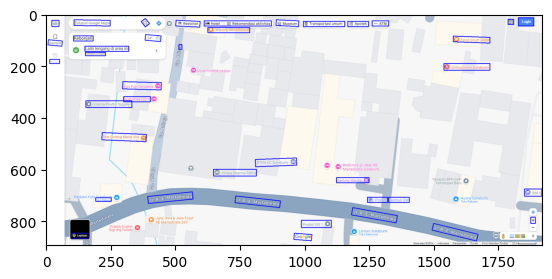

In [21]:
# Hitung Waktu
start_time = time.time()

#initiate browser
driver = webdriver.Chrome(options=chrome_options)

# first screenshoot
path_first_screenshoot = make_screenshot(driver, get_gmaps_link(lat_test, long_test, zoom1), f"{path_output}/screenshoot_zoom_1.png")

# Periksa ukuran resolusi gambar
res_x, res_y = get_image_resolution(path_first_screenshoot)

# Import SHP
geo_df_kota = gpd.read_file(path_shp)
geo_df_kota.head()
geo_kelurahan = geo_df_kota[(geo_df_kota["WADMKC"]==kecamatan) & (geo_df_kota["WADMKD"]==kelurahan)]["geometry"]

# grid size
x1_size, y1_size = calculate_grid_size(res_x,res_y,zoom1)
x2_size, y2_size = calculate_grid_size(res_x,res_y,zoom2)
x3_size, y3_size = calculate_grid_size(res_x,res_y,zoom3)

# make grid maps
grid1 = create_grid(geo_kelurahan,x1_size,y1_size)
grid3 = create_grid(geo_kelurahan,x3_size,y3_size)

# centroid of each grid
grid1 = get_centroid(grid1)
grid3 = get_centroid(grid3)

# Initiate Dataframe hasil
df_result = pd.DataFrame()

# looping zoom 1
for i in range(len(grid1)):
    l = get_gmaps_link(round(grid1['centroid'][i].y,7), round(grid1['centroid'][i].x,7),zoom1)
    img = make_screenshot(driver, l,f"{path_output}screenshoot/zoom1_{i+1}.png")
    # img=f"{path_output}screenshoot/zoom1_{i+1}.png"
    
    result = detect_text(img, link_map=l)
    save_image_with_boxes(img,result['boxes'],f"{path_output}ocr_result/zoom1_{i+1}.png")
    clean_result = cleaning_text(result)
    df_result = collect_place(df_result, clean_result)


save(df_result, f"{path_output}hasil OCR tingkat zoom {zoom1}.csv")

df_result = get_places_detail(driver, df_result)
save(df_result, f"{path_output}hasil scrapping detail tingkat zoom {zoom1}.csv")

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Waktu eksekusi sampai looping 1: {elapsed_time} detik")

In [ ]:
# # Initiate Dataframe hasil
# df_result_3 = pd.DataFrame()

# # looping zoom 3
# for i in range(len(grid3)):
#     l = get_gmaps_link(round(grid3['centroid'][i].y,7), round(grid3['centroid'][i].x,7),zoom3)
#     img = make_screenshot(driver, l,f"{path_output}screenshoot/zoom3_{i+1}.png")
#     # img=f"{path_output}screenshoot/zoom3_{i+1}.png"
    
#     result = detect_text(img, link_map=l)
#     save_image_with_boxes(img,result['boxes'],f"{path_output}ocr_result/zoom3_{i+1}.png")
#     clean_result = cleaning_text(result)
#     df_result3 = pd.concat([df_result3, clean_result], ignore_index=True, axis=0)
 
    
# save(df_result3, f"{path_output}hasil OCR tingkat zoom {zoom3}.csv")

# df_result3 = get_places_detail(driver, df_result3)
# save(df_result, f"{path_output}hasil scrapping dengan tambahan tingkat zoom {zoom3}.csv")

# driver.quit()

# end_time = time.time()
# elapsed_time = end_time - start_time
# print(f"Waktu eksekusi sampai looping 2: {elapsed_time} detik")

In [ ]:
driver.quit()